#Download dataset dari https://www.kaggle.com/datasets/shubhamgoel27/dermnet

Dataset ini terdiri dari 23 kelas dengan total 19k image:

Eczema Photos

Tinea Ringworm Candidiasis and other Fungal Infections

Acne and Rosacea Photos

Scabies Lyme Disease and other Infestations and Bites

Poison Ivy Photos and other Contact Dermatitis

Vasculitis Photos

Urticaria Hives

Light Diseases and Disorders of Pigmentation

Melanoma Skin Cancer Nevi and Moles

Nail Fungus and other Nail Disease

Atopic Dermatitis Photos

Vascular Tumors

Psoriasis pictures Lichen Planus and related diseases

Cellulitis Impetigo and other Bacterial Infections

Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions

Systemic Disease

Herpes HPV and other STDs Photos

Hair Loss Photos Alopecia and other Hair Diseases

Seborrheic Keratoses and other Benign Tumors

Warts Molluscum and other Viral Infections

Bullous Disease Photos

Exanthems and Drug Eruptions

Lupus and other Connective Tissue diseases

In [1]:
# Download Dataset
!pip install -q kaggle

!mkdir ~/.kaggle
!mkdir dermnet

!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'shubhamgoel27/dermnet'

100% 1.72G/1.72G [00:19<00:00, 81.5MB/s]
100% 1.72G/1.72G [00:19<00:00, 96.0MB/s]


In [2]:
# Extract file zip
import zipfile

dataset_zip = zipfile.ZipFile('dermnet.zip', 'r')
dataset_zip.extractall('dermnet')
dataset_zip.close()

In [3]:
import os
import random
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

#Oversampling dataset karena distibusi datanya tidak merata serta menghapus kelas yang datanya kurang dari 500

In [5]:
# Menghitung jumlah gambar di setiap folder kelas
def count_images(folder):
    count = 0
    for _, _, files in os.walk(folder):
        count += len(files)
    return count

# Oversampling
def oversample(folder, target_count):
    image_files = os.listdir(folder)
    current_count = len(image_files)
    oversample_count = target_count - current_count

    while oversample_count > 0:
        random_file = random.choice(image_files)
        source = os.path.join(folder, random_file)
        new_file = os.path.splitext(random_file)[0] + '_oversampled' + os.path.splitext(random_file)[1]
        destination = os.path.join(folder, new_file)
        shutil.copy(source, destination)
        image_files.append(new_file)
        oversample_count -= 1

train_folder = 'dermnet/train'
test_folder = 'dermnet/test'
output_folder = 'dataset'
os.makedirs(output_folder, exist_ok=True)

combined_folder = os.path.join(output_folder, 'combined')
os.makedirs(combined_folder, exist_ok=True)

# Memindahkan data train ke folder combined
train_classes = os.listdir(train_folder)
for train_class in train_classes:
    train_class_path = os.path.join(train_folder, train_class)
    combined_class_path = os.path.join(combined_folder, train_class)
    shutil.copytree(train_class_path, combined_class_path, dirs_exist_ok=True)

# Memindahkan data test ke folder combined
test_classes = os.listdir(test_folder)
for test_class in test_classes:
    test_class_path = os.path.join(test_folder, test_class)
    combined_class_path = os.path.join(combined_folder, test_class)
    shutil.copytree(test_class_path, combined_class_path, dirs_exist_ok=True)

def print_image_counts(folder):
    print(f"\nJumlah gambar di folder {folder}:")
    class_folders = os.listdir(folder)
    for class_folder in class_folders:
        class_folder_path = os.path.join(folder, class_folder)
        image_count = count_images(class_folder_path)
        print(f"- {class_folder}: {image_count} gambar")

print_image_counts(combined_folder)

# Menghapus folder kelas dengan jumlah data kurang dari 500
for class_folder in os.listdir(combined_folder):
    class_folder_path = os.path.join(combined_folder, class_folder)
    if count_images(class_folder_path) < 500:
        shutil.rmtree(class_folder_path)

print_image_counts(combined_folder)

# Mengoversampling kelas yang tersisa
for class_folder in os.listdir(combined_folder):
    class_folder_path = os.path.join(combined_folder, class_folder)
    oversample(class_folder_path, 1500)

# Memindahkan gambar ke folder tujuan
def move_images(source_folder, destination_folder, count):
    images = random.sample(os.listdir(source_folder), count)
    for image in images:
        source = os.path.join(source_folder, image)
        destination = os.path.join(destination_folder, image)
        shutil.move(source, destination)

# Perbandingan jumlah data untuk train, validation, dan test
train_ratio = 7
validation_ratio = 1.5
test_ratio = 1.5

dataset_folder = 'dataset'
train_folder = 'train'
validation_folder = 'validation'
test_folder = 'test'

train_folder_path = os.path.join(dataset_folder, train_folder)
validation_folder_path = os.path.join(dataset_folder, validation_folder)
test_folder_path = os.path.join(dataset_folder, test_folder)

# Membuat folder train, validation, dan test
os.makedirs(train_folder_path, exist_ok=True)
os.makedirs(validation_folder_path, exist_ok=True)
os.makedirs(test_folder_path, exist_ok=True)

# Memindahkan image ke folder train, validation, dan test
for class_folder in os.listdir(combined_folder):
    class_folder_path = os.path.join(combined_folder, class_folder)
    train_count = int(count_images(class_folder_path) * train_ratio / (train_ratio + validation_ratio + test_ratio))
    validation_count = int(count_images(class_folder_path) * validation_ratio / (train_ratio + validation_ratio + test_ratio))
    test_count = count_images(class_folder_path) - train_count - validation_count

    train_class_folder_path = os.path.join(train_folder_path, class_folder)
    validation_class_folder_path = os.path.join(validation_folder_path, class_folder)
    test_class_folder_path = os.path.join(test_folder_path, class_folder)

    os.makedirs(train_class_folder_path, exist_ok=True)
    os.makedirs(validation_class_folder_path, exist_ok=True)
    os.makedirs(test_class_folder_path, exist_ok=True)

    move_images(class_folder_path, train_class_folder_path, train_count)
    move_images(class_folder_path, validation_class_folder_path, validation_count)
    move_images(class_folder_path, test_class_folder_path, test_count)



Jumlah gambar di folder dataset/combined:
- Eczema Photos: 1544 gambar
- Tinea Ringworm Candidiasis and other Fungal Infections: 1625 gambar
- Acne and Rosacea Photos: 882 gambar
- Scabies Lyme Disease and other Infestations and Bites: 539 gambar
- Poison Ivy Photos and other Contact Dermatitis: 325 gambar
- Vasculitis Photos: 521 gambar
- Urticaria Hives: 265 gambar
- Light Diseases and Disorders of Pigmentation: 711 gambar
- Melanoma Skin Cancer Nevi and Moles: 579 gambar
- Nail Fungus and other Nail Disease: 1301 gambar
- Atopic Dermatitis Photos: 612 gambar
- Vascular Tumors: 603 gambar
- Psoriasis pictures Lichen Planus and related diseases: 1757 gambar
- Cellulitis Impetigo and other Bacterial Infections: 361 gambar
- Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 1437 gambar
- Systemic Disease: 758 gambar
- Herpes HPV and other STDs Photos: 507 gambar
- Hair Loss Photos Alopecia and other Hair Diseases: 299 gambar
- Seborrheic Keratoses and other Benign Tum

In [6]:
print_image_counts(train_folder_path)
print_image_counts(validation_folder_path)
print_image_counts(test_folder_path)


Jumlah gambar di folder dataset/train:
- Eczema Photos: 1080 gambar
- Tinea Ringworm Candidiasis and other Fungal Infections: 1137 gambar
- Acne and Rosacea Photos: 968 gambar
- Scabies Lyme Disease and other Infestations and Bites: 797 gambar
- Vasculitis Photos: 784 gambar
- Light Diseases and Disorders of Pigmentation: 888 gambar
- Melanoma Skin Cancer Nevi and Moles: 826 gambar
- Nail Fungus and other Nail Disease: 1042 gambar
- Atopic Dermatitis Photos: 840 gambar
- Vascular Tumors: 830 gambar
- Psoriasis pictures Lichen Planus and related diseases: 1229 gambar
- Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 1049 gambar
- Systemic Disease: 912 gambar
- Herpes HPV and other STDs Photos: 781 gambar
- Seborrheic Keratoses and other Benign Tumors: 1199 gambar
- Warts Molluscum and other Viral Infections: 1045 gambar
- Bullous Disease Photos: 809 gambar
- Exanthems and Drug Eruptions: 779 gambar
- Lupus and other Connective Tissue diseases: 778 gambar

Jumlah gam

#Image Augmentation

In [7]:
# Path dataset folder
dataset_path = 'dataset'

# Paths train, validation, and test folders
train_folder = os.path.join(dataset_path, 'train')
validation_folder = os.path.join(dataset_path, 'validation')
test_folder = os.path.join(dataset_path, 'test')

def train_val_generators():
    train_datagen = ImageDataGenerator(
            # rotation_range=30,
            # width_shift_range=0.2,
            # height_shift_range=0.2,
            # brightness_range=[0.7, 1.3],
            # shear_range=0.2,
            # zoom_range=0.3,
            # horizontal_flip=True,
            # vertical_flip=True,
            # fill_mode='nearest',
            rescale=1./255
    )
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        #color_mode='grayscale',
        batch_size=32,
        class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(224, 224),
        #color_mode='grayscale',
        batch_size=32,
        class_mode='categorical'
    )
    
    return train_generator, validation_generator

train_generator, validation_generator = train_val_generators()


Found 17773 images belonging to 19 classes.
Found 3801 images belonging to 19 classes.


#Transfer Learning Model

In [8]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Base Model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(19, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

#Training Model

In [9]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/50
556/556 [==============================] - 205s 332ms/step - loss: 2.7858 - accuracy: 0.1727 - val_loss: 2.4620 - val_accuracy: 0.2881
Epoch 2/50
556/556 [==============================] - 173s 311ms/step - loss: 2.5229 - accuracy: 0.2380 - val_loss: 2.3142 - val_accuracy: 0.3215
Epoch 3/50
556/556 [==============================] - 173s 310ms/step - loss: 2.4265 - accuracy: 0.2636 - val_loss: 2.2609 - val_accuracy: 0.3418
Epoch 4/50
556/556 [==============================] - 175s 315ms/step - loss: 2.3757 - accuracy: 0.2803 - val_loss: 2.2322 - val_accuracy: 0.3496
Epoch 5/50
556/556 [==============================] - 182s 326ms/step - loss: 2.3226 - accuracy: 0.2929 - val_loss: 2.1691 - val_accuracy: 0.3536
Epoch 6/50
556/556 [==============================] - 185s 332ms/step - loss: 2.3055 - accuracy: 0.3012 - val_loss: 2.1873 - val_accuracy: 0.3675
Epoch 7/50
556/556 [==============================] - 176s 316ms/step - loss: 2.2762 - accuracy: 0.3114 - val_loss: 2.1819 -

#Fine Tuning

In [10]:
# Unfreeze semua layer
for layer in base_model.layers:
    layer.trainable = True

# Compile model dengan learning rate yang lebih rendah dari sebelumnya
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)

history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/100
556/556 [==============================] - 429s 596ms/step - loss: 2.6799 - accuracy: 0.2199 - val_loss: 2.1394 - val_accuracy: 0.3883
Epoch 2/100
556/556 [==============================] - 329s 592ms/step - loss: 2.2152 - accuracy: 0.3335 - val_loss: 1.9347 - val_accuracy: 0.4607
Epoch 3/100
556/556 [==============================] - 330s 593ms/step - loss: 2.0173 - accuracy: 0.3908 - val_loss: 1.7858 - val_accuracy: 0.5043
Epoch 4/100
556/556 [==============================] - 329s 592ms/step - loss: 1.8529 - accuracy: 0.4337 - val_loss: 1.6723 - val_accuracy: 0.5514
Epoch 5/100
556/556 [==============================] - 341s 613ms/step - loss: 1.7116 - accuracy: 0.4801 - val_loss: 1.5738 - val_accuracy: 0.5809
Epoch 6/100
556/556 [==============================] - 329s 590ms/step - loss: 1.5970 - accuracy: 0.5149 - val_loss: 1.4911 - val_accuracy: 0.6041
Epoch 7/100
556/556 [==============================] - 328s 589ms/step - loss: 1.4726 - accuracy: 0.5539 - val_loss: 1

In [ ]:
# Compile model dengan learning rate yang lebih rendah dari sebelumnya
model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)

history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[early_stopping])

In [ ]:
# Compile model dengan learning rate yang lebih rendah dari sebelumnya
model.compile(optimizer=Adam(learning_rate=1e-9), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=9, restore_best_weights=True)

history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[early_stopping])

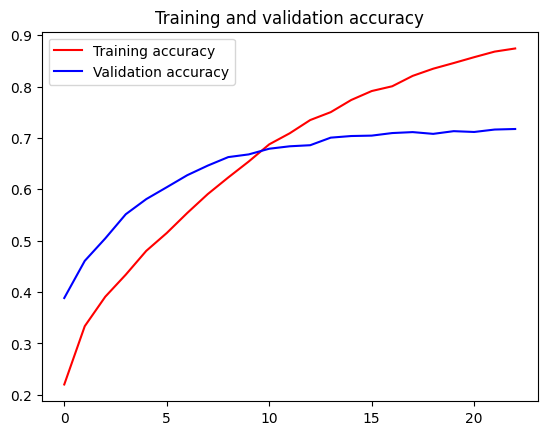

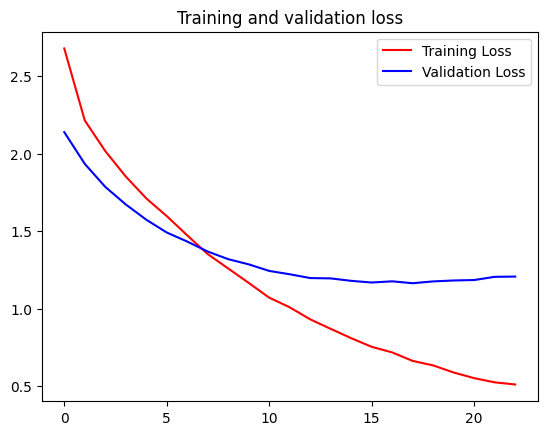

In [11]:
# Plot chart untuk accuracy and loss di training dan validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# Test Images
test_folder = 'dataset/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(224, 224),
        #color_mode='grayscale',
        batch_size=32,
        class_mode='categorical'
    )

loss, accuracy = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

print("Predicted Labels:")
print(predicted_labels)

# class_names = list(test_generator.class_indices.keys())
# predicted_class_names = [class_names[idx] for idx in predicted_labels]

# print("Predicted Labels:")
# print(predicted_class_names)

Found 3827 images belonging to 19 classes.
120/120 [==============================] - 33s 272ms/step - loss: 1.1685 - accuracy: 0.7094
Test Loss: 1.1685293912887573
Test Accuracy: 0.7094329595565796
120/120 [==============================] - 32s 268ms/step
Predicted Labels:
[14  8  7 ... 12 12 17]


In [15]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [21]:
import tensorflowjs as tfjs

# Ekspor model ke TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model_skinsight')

!zip -r tfjs_model_skinsight.zip tfjs_model_skinsight

  adding: tfjs_model_skinsight/ (stored 0%)
  adding: tfjs_model_skinsight/group1-shard11of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard6of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard12of13.bin (deflated 7%)
  adding: tfjs_model_skinsight/group1-shard5of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard2of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard4of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard13of13.bin (deflated 7%)
  adding: tfjs_model_skinsight/group1-shard1of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard10of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard9of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard8of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/group1-shard3of13.bin (deflated 6%)
  adding: tfjs_model_skinsight/model.json (deflated 96%)
  adding: tfjs_model_skinsight/group1-shard7of13.bin (deflated 6%)


In [18]:
# Menyimpan model ke file TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
with open('model_skinsight.tflite', 'wb') as f:
    f.write(tflite_model)

In [19]:
# Menyimpan model ke h5
model.save('model_skinsight.h5')